In [476]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time
import data_manipulator
import create_model
import data_reader
import finance_calculator
import latex

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

In [477]:
# load back history data
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
ASSET_TO_PREDICT = 'ty1'                  #--- VAR CHANGE
with open('models/last_run_model_name.txt') as f:
    last_model_name = f.readline()
    print(last_model_name)
model_name = last_model_name        #--- VAR CHANGE
model_load = keras.models.load_model(f'models/{model_name}.hdf5')
history_load = np.load(f'history/{model_name}.npy',allow_pickle='TRUE').item()

01.23.0148-ty1-60-1-lstm-sigmoid


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


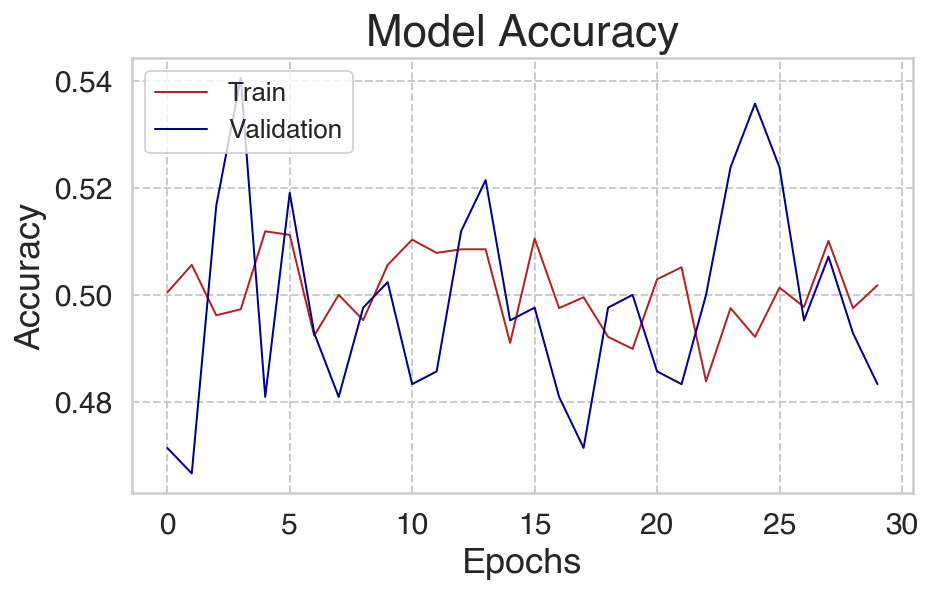

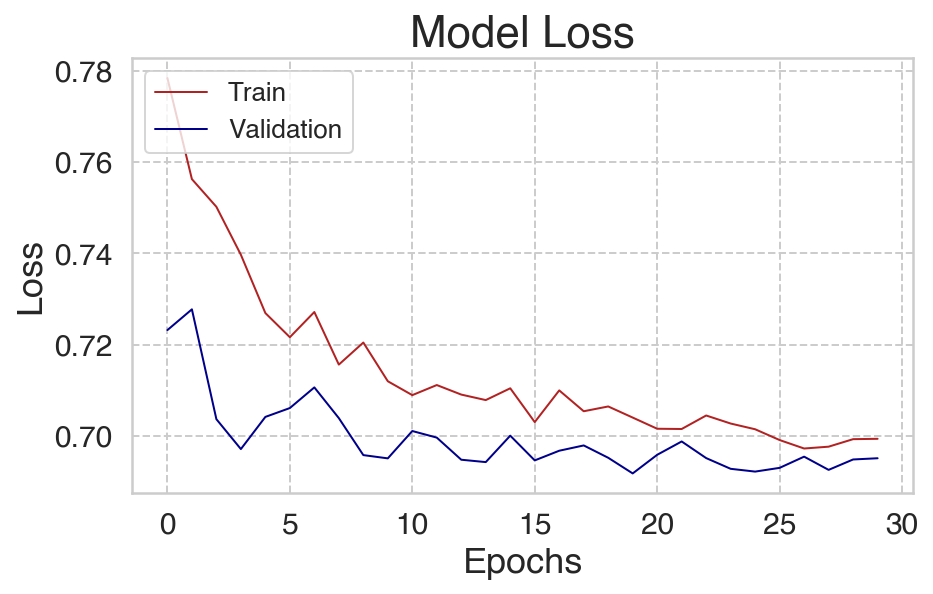

In [478]:
fig1, axs1 = utils.plot_history_data_accuracy(history_load)
plt.tick_params(axis='both', which='major', labelsize=15)
save_loc = f'plots/{last_model_name}_model_accuracy.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

fig2, axs2 = utils.plot_history_data_loss(history_load)
plt.tick_params(axis='both', which='major', labelsize=15)
save_loc = f'plots/{last_model_name}_model_loss.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

In [479]:
# CREDIT DATA
credit_df = pd.DataFrame() # begin empty
rx1, ty1, ik1, oe1, du1 = data_reader.credit()
# credit_df['rx1'] = rx1['RX1 Comdty']             # --VAR CHANGE 
credit_df['ty1'] = ty1['TY1 Comdty']
# credit_df['ik1'] = ik1['IK1 Comdty']
# credit_df['oe1'] = oe1['OE1 Comdty']
# credit_df['du1'] = du1['DU1 Comdty']

# CRYPTO DATA
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]
crypto_df = data_reader.crypto(ratios)

# set dataset                              
dataset_df = credit_df                      # --VAR CHANGE 

val_df = data_manipulator.splitter(dataset_df, cutoff=0.10)[1]

df_rp = utils.getReturnAndPred_sigmoidModel(val_df, SEQ_LEN+1, ASSET_TO_PREDICT, model_load)

[0.5240629]
[0.5122533]
[0.49650303]
[0.5027626]
[0.4990916]
[0.48222572]
[0.505335]
[0.490429]
[0.48160088]
[0.48952225]
[0.48173538]
[0.47396123]
[0.49191943]
[0.49649698]
[0.4893693]
[0.5012179]
[0.52862537]
[0.52258044]
[0.5052255]
[0.5254527]
[0.54197097]
[0.5456907]
[0.51978093]
[0.50563276]
[0.5202006]
[0.5476621]
[0.5609299]
[0.543326]
[0.5204888]
[0.51459897]
[0.50578165]
[0.50253665]
[0.50114787]
[0.5024687]
[0.50606346]
[0.49937555]
[0.5070043]
[0.5007568]
[0.50694245]
[0.5109506]
[0.5090244]
[0.47592214]
[0.481401]
[0.5022557]
[0.51821744]
[0.5274786]
[0.53424567]
[0.53683484]
[0.530165]
[0.53060645]
[0.54327536]
[0.55093914]
[0.49529502]
[0.44868535]
[0.47273576]
[0.48721892]
[0.49628448]
[0.48349476]
[0.46595123]
[0.4550921]
[0.4580507]
[0.4719025]
[0.49168822]
[0.51353014]
[0.52971816]
[0.5475163]
[0.53591853]
[0.5280374]
[0.5157706]
[0.49344835]
[0.48440015]
[0.48617625]
[0.50044024]
[0.5096115]
[0.51347876]
[0.5172953]
[0.5135926]
[0.51661104]
[0.52251405]
[0.5226504]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Mean of 20 first predictions 0.5020162


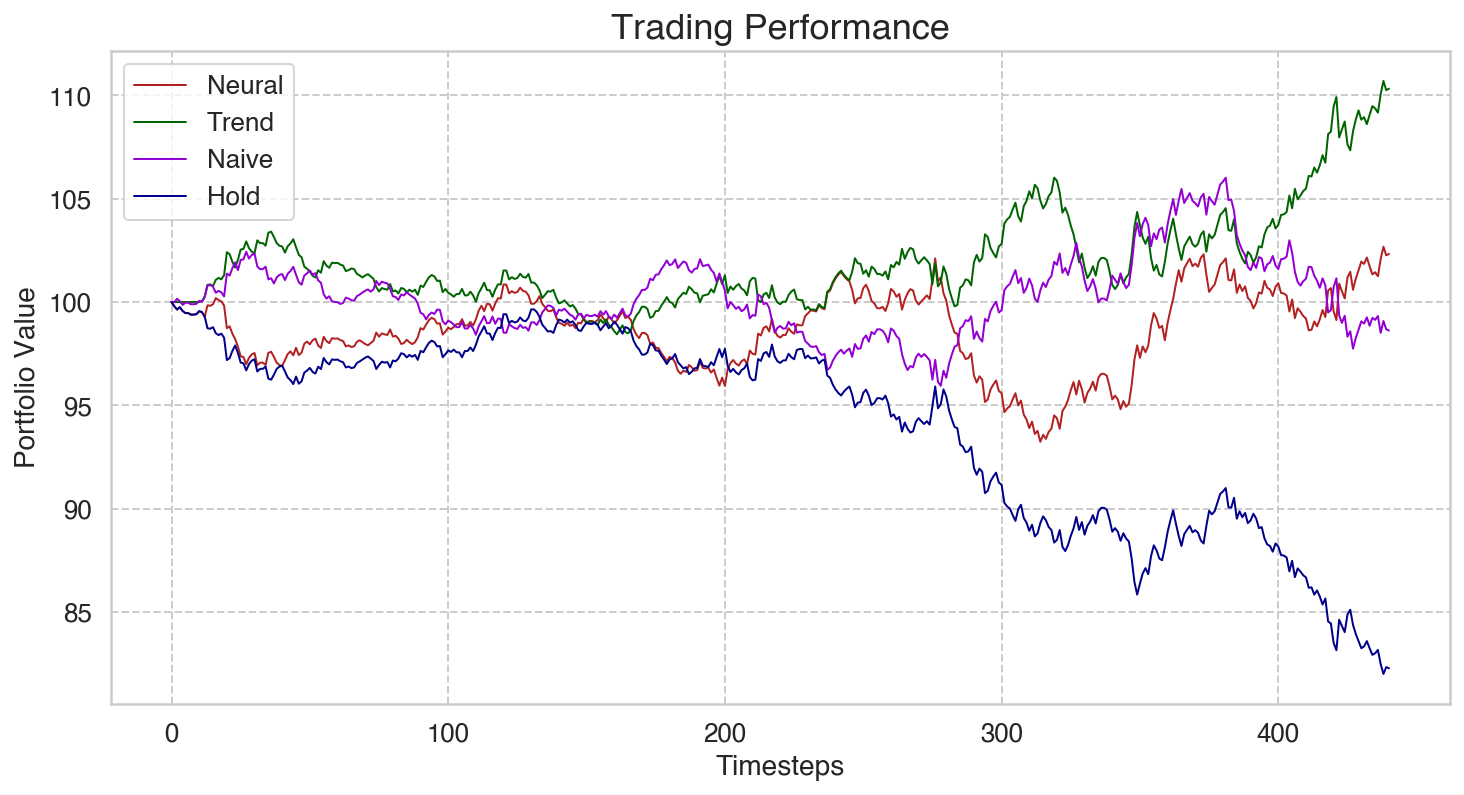

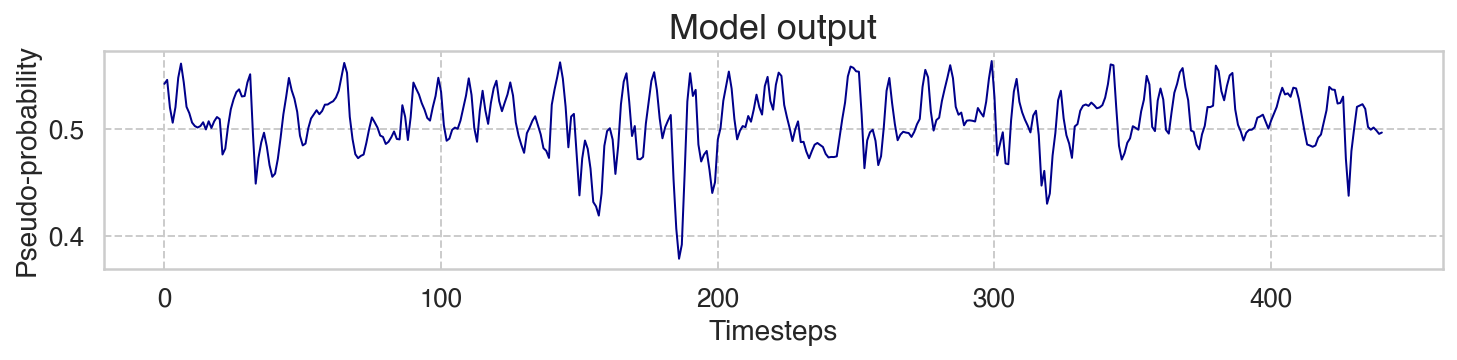

In [480]:
n = 20                       #--- VAR CHANGE
first_n_predictions = df_rp.loc[0:n, 'probability_up']
mean = np.mean(first_n_predictions)
print(f'Mean of {n} first predictions', mean)

treshhold = mean # 0 = always short, 1 = always long. mean ~ 50/50 short/long
copy_df = df_rp[n:].reset_index(drop=True)

# Portfolio values
portfolio_value_neural = finance_calculator.portfolio_value_neural(copy_df, treshhold)
nbr_previous_days = 10
portfolio_value_trend = finance_calculator.portfolio_value_trend(copy_df, nbr_previous_days)
portfolio_value_naive = finance_calculator.portfolio_value_naive(copy_df)
portfolio_value_hold = finance_calculator.portfolio_value_hold(copy_df)

# Plots
fig1, axs1 = plt.subplots(1,1, figsize=(12,6))
plt.tick_params(axis='both', which='major', labelsize=13)
fig1 = plt.plot(portfolio_value_neural, color='firebrick', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_trend, color='darkgreen', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_naive, color='darkviolet', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_hold, color='darkblue', linestyle='-', linewidth='1')
axs1 = plt.title('Trading Performance', size=18)
axs1 = plt.ylabel('Portfolio Value', size=14)
axs1 = plt.xlabel('Timesteps', size=14)
axs1 = plt.legend(['Neural', 'Trend', 'Naive', 'Hold'], loc='upper left')
save_loc = f'plots/{last_model_name}_trading_performance.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

# Model output
fig2, axs2 = plt.subplots(1,1, figsize=(12,2))
plt.tick_params(axis='both', which='major', labelsize=13)
fig2 = plt.plot(copy_df['probability_up'], color='darkblue', linewidth='1')
axs2 = plt.title('Model output', size=18)
axs2 = plt.ylabel('Pseudo-probability', size=14)
axs2 = plt.xlabel('Timesteps', size=14)
save_loc = f'plots/{last_model_name}_model_output.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")


In [481]:
# Statistics
finance_calculator.confusion_stats_neural(copy_df, treshhold)
correlation = np.corrcoef(portfolio_value_neural, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))

finance_calculator.confusion_stats_trend(copy_df, nbr_previous_days)
correlation = np.corrcoef(portfolio_value_trend, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))

finance_calculator.confusion_stats_naive(copy_df)
correlation = np.corrcoef(portfolio_value_naive, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))



NEURAL STATS:
TP: 120
FP: 138
TN: 95
FN: 88
True positive rate: 57.69%
True negative rate: 40.77%
Positive predictive value: 46.51%
Negative predictive value: 51.91%
Correlation: -1.75%

TREND STATS:
TP: 69
FP: 83
TN: 145
FN: 134
True positive rate: 33.99%
True negative rate: 63.60%
Positive predictive value: 45.39%
Negative predictive value: 51.97%
Correlation: -83.98%

NAIVE STATS:
TP: 99
FP: 108
TN: 124
FN: 109
True positive rate: 47.60%
True negative rate: 53.45%
Positive predictive value: 47.83%
Negative predictive value: 53.22%
Correlation: -34.76%


In [482]:
# Financial Metrics
one_year_of_returns = 365 #number of datapoints that equals one year of return data in portfolio value

print('NEURAL')
returns_neural = finance_calculator.daily_returns(portfolio_value_neural)
sharpe_neural = finance_calculator.sharpe_ratio(returns_neural, one_year_of_returns, 0.02)
sortino_neural = finance_calculator.sortino_ratio(returns_neural, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_neural))
print("Sortino-ratio: {:5.2f}".format(sortino_neural))
gross_return_neural = finance_calculator.gross_return(portfolio_value_trading)
print("Gross return: {:5.2f}%".format(100 * gross_return_neural))

print('')
print('TREND')
returns_trend = finance_calculator.daily_returns(portfolio_value_trend)
sharpe_trend = finance_calculator.sharpe_ratio(returns_trend, one_year_of_returns, 0.02)
sortino_trend = finance_calculator.sortino_ratio(returns_trend, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_trend))
print("Sortino-ratio: {:5.2f}".format(sortino_trend))
gross_return_trend = finance_calculator.gross_return(portfolio_value_trend)
print("Gross return: {:5.2f}%".format(100 * gross_return_trend))

print('')
print('NAIVE')
returns_naive = finance_calculator.daily_returns(portfolio_value_naive)
sharpe_naive = finance_calculator.sharpe_ratio(returns_naive, one_year_of_returns, 0.02)
sortino_naive = finance_calculator.sortino_ratio(returns_naive, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_naive))
print("Sortino-ratio: {:5.2f}".format(sortino_naive))
gross_return_naive = finance_calculator.gross_return(portfolio_value_naive)
print("Gross return: {:5.2f}%".format(100 * gross_return_naive))


print('')
print('HOLD')
returns_hold = finance_calculator.daily_returns(portfolio_value_hold)
sharpe_hold = finance_calculator.sharpe_ratio(returns_hold, one_year_of_returns, 0.02)
sortino_hold = finance_calculator.sortino_ratio(returns_hold, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_hold))
print("Sortino-ratio: {:5.2f}".format(sortino_hold))
gross_return_hold = finance_calculator.gross_return(portfolio_value_hold)
print("Gross return: {:5.2f}%".format(100 * gross_return_hold))



NEURAL
Sharpe-ratio:  0.03
Sortino-ratio:  0.04
Gross return: -4.27%

TREND
Sharpe-ratio:  0.85
Sortino-ratio:  1.31
Gross return: 10.33%

NAIVE
Sharpe-ratio: -0.38
Sortino-ratio: -0.54
Gross return: -1.38%

HOLD
Sharpe-ratio: -2.37
Sortino-ratio: -3.45
Gross return: -17.72%
